# Sobol analysis

In this notebook, the Sobol analysis is performed. A Sobol analysis explores the effect of the model input parameters on the model outcomes. 

First, the model is loaded.

In [1]:
#Import the EMA workbench
from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging)
from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench import MultiprocessingEvaluator
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS
import ema_workbench

__all__ = ['NetLogoLink',
           'NetLogoException']

from ema_workbench import (Constant, TimeSeriesOutcome, IntegerParameter, RealParameter, BooleanParameter, SequentialEvaluator, MultiprocessingEvaluator, ScalarOutcome, ema_logging, perform_experiments, ArrayOutcome, Policy)
from ema_workbench.connectors import netlogo
from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.evaluators import SOBOL
from SALib.analyze import sobol
from ema_workbench import save_results

#Import the other packages
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

C:\Users\kkiim\anaconda3\lib\site-packages\ema_workbench\connectors\__init__.py:17: ImportWarning: vensim connector not available
  warnings.warn("vensim connector not available", ImportWarning)


In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

#Define the model outcomes 

outcomes = [TimeSeriesOutcome('legal_products_end_user'),
            TimeSeriesOutcome('illegal_EU_products_end_user'),
            TimeSeriesOutcome('NOP_products_end_user')
           ]

#Define the NetLogo model
nl_model = NetLogoModel('NetLogo', wd = os.getcwd(), model_file="Netlogo_model/Crop_protection_products_NL_final.nlogo")
nl_model.run_length = int(396)
nl_model.replications = 50
nl_model.uncertainties = [IntegerParameter('%_always_comply_end_users', 0, 100),
                         RealParameter('%_always_comply_traders', 0, 100),
                         RealParameter('%_traders_end_user_only', 10, 90),
                         RealParameter('%_coverage_of_disease_crop_combinations_legal_products', 10, 100),
                         IntegerParameter('minimum_profit', 0, 5000), 
                         IntegerParameter('inspection_chance_NL_border', 0, 50),
                         IntegerParameter('nr_of_PPPs_inspected_upon_visit_trader', 1, 50),
                         RealParameter('inspect_end_user_only_traders_EMA', 0, 1),
                         RealParameter('inspect_trader_to_trader_only_traders_EMA', 0, 1),
                         IntegerParameter('Nr_of_inspectors', 1, 10),
                         RealParameter('%_profiling_used', 0, 100)
                         ]
nl_model.outcomes = outcomes
nl_model.constants = [Constant('progression_visualisation?', False),
                     Constant('fixed-seed?', False),
                     Constant('Nr_of_types_of_crops', 5),
                     Constant('Nr_of_types_of_diseases', 2),
                     Constant('Nr_of_end_users', 300),
                     Constant ('Nr_of_traders', 15),
                     Constant('fixed_trust_period', 36),
                     Constant('fine-to-profit_ratio', 1),
                     Constant('%_avg_chance_to_get_disease', 5),
                     Constant('nr_of_PPPs_inspected_upon_visit_end_user', 3),
                     Constant('inspect_end_users_EMA', 1)
                 ] 

With the model, the Sobol sampling is performed. The model is replicated 50 times for every scenario and a 100 scenarios are performed per combination of parameter settings. 

In [4]:
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(nl_model, n_processes = 8) as evaluator:
    sobol_experiments, sobol_outcomes = evaluator.perform_experiments(scenarios=100, uncertainty_sampling=SOBOL)

[MainProcess/INFO] pool started
C:\Users\kkiim\anaconda3\lib\site-packages\SALib\sample\saltelli.py:52: FutureWarning: 
        Convergence properties of the Sobol' sequence is only valid if `N` = 2^n.
        SALib will continue on, but results may have issues.
        In future, this will raise an error.
        
  warnings.warn(msg, FutureWarning)
[MainProcess/INFO] performing 2400 scenarios * 1 policies * 1 model(s) = 2400 experiments
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] 480 cases completed
[MainProcess/INFO] 720 cases completed
[MainProcess/INFO] 960 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1440 cases completed
[MainProcess/INFO] 1680 cases completed
[MainProcess/INFO] 1920 cases completed
[MainProcess/INFO] 2160 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [5]:
# Save the results
a_file = open("Results/data_SOBOL_COMPLETE.pkl", "wb")
pickle.dump(sobol_outcomes, a_file)
a_file.close()

sobol_experiments.to_pickle("Results/experiments_SOBOL_COMPLETE.pkl")

First, the model run results must be averaged over the scenarios and percentages must be calculated.

In [10]:
#Create a function that averages over all the model runs per scenario per type of model outcome 
#(legal, NOP and illegal in the EU products)
new_df = pd.DataFrame(columns=['legal_products_end_user', 'illegal_EU_products_end_user', 'NOP_products_end_user'])
def append_outcome_to_dataset(type_of_product):

    #Get the desired model outcome
    products = opened_results.get(type_of_product)
    outcome_list = []
    averaged = []
    
    #Average over the lists in the dictionary to get the average values per scenario 
    for i in products:
        averaged = np.average(i, axis=0)
        last_value = averaged[-1]
        outcome_list.append(last_value)
        
    #Append the average value to the experiments dataframe
    new_df[type_of_product] = outcome_list

In [11]:
#Create a function that expresses the outcome of interest as a percentage
def get_percentage(row, outcome_of_interest):
    
    #Retrieve the total products that reach the end user and the value of the outcome of interest
    sum_products = row['legal_products_end_user'] + row['illegal_EU_products_end_user'] + row['NOP_products_end_user']
    product_of_interest = row[outcome_of_interest]
    
    #Return the rounded percentage
    return round (product_of_interest / sum_products * 100, 2)

In [12]:
opened_results = pd.read_pickle("Results/data_SOBOL_COMPLETE.pkl")
opened_results

{'legal_products_end_user': array([[[   0.,   16.,   37., ..., 6308., 6321., 6335.],
         [   0.,   10.,   24., ..., 6699., 6717., 6729.],
         [   0.,   18.,   35., ..., 6493., 6510., 6530.],
         ...,
         [   0.,   12.,   29., ..., 3819., 3827., 3828.],
         [   0.,   10.,   30., ..., 5881., 5892., 5906.],
         [   0.,    9.,   21., ..., 4743., 4756., 4769.]],
 
        [[   0.,   12.,   41., ..., 6737., 6752., 6765.],
         [   0.,   14.,   31., ..., 6768., 6779., 6794.],
         [   0.,   11.,   25., ..., 6402., 6415., 6431.],
         ...,
         [   0.,   12.,   21., ..., 6416., 6432., 6450.],
         [   0.,   16.,   25., ..., 6723., 6743., 6762.],
         [   0.,   14.,   29., ..., 6460., 6476., 6490.]],
 
        [[   0.,    8.,   17., ..., 5913., 5933., 5955.],
         [   0.,   18.,   42., ..., 6075., 6089., 6106.],
         [   0.,   15.,   27., ..., 6465., 6480., 6496.],
         ...,
         [   0.,   15.,   28., ..., 5741., 5754., 5769.

In [13]:
#Append the average outcomes per scenario to the dataset
append_outcome_to_dataset("legal_products_end_user")
append_outcome_to_dataset("illegal_EU_products_end_user")
append_outcome_to_dataset("NOP_products_end_user")

#Create the percentages
new_df['%_illegal_EU_products_end_user'] = new_df.apply (lambda row: get_percentage(row, 'illegal_EU_products_end_user' ), axis=1)
new_df['%_NOP_products_end_user'] = new_df.apply (lambda row: get_percentage(row, 'NOP_products_end_user' ), axis=1)
new_df['%_illegal_total'] = new_df.apply(lambda row: row['%_illegal_EU_products_end_user'] + row['%_NOP_products_end_user'], axis=1)

Next, the data can be used to create a visualisation of the Sobol sampling. 

In [14]:
#Create a function that produces a Sobol plot
def create_SOBOL_plot(output_variable):
    
    #Get the Salib problem
    problem = get_SALib_problem(nl_model.uncertainties)
    Si = sobol.analyze(problem, new_df[output_variable].to_numpy(), calc_second_order=True)

    #Get the relevant outcomes from the Sobol calculations
    Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])

    #Create the plot
    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(8,6)
    fig.subplots_adjust(bottom=0.3)
    plt.title("SOBOL analysis " + output_variable)
    plt.show()

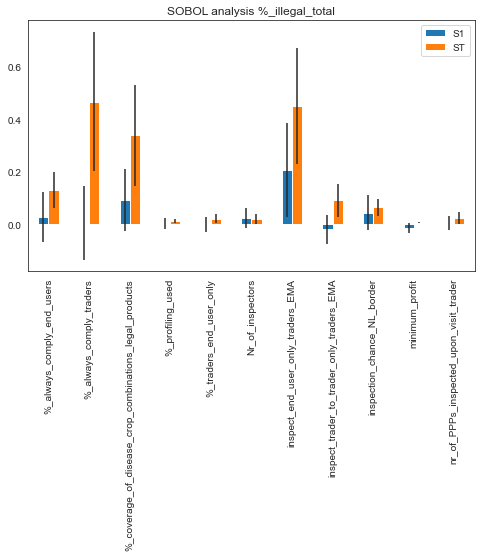

In [15]:
#Create the plot for the percentage of total illegal products reaching the end-user
create_SOBOL_plot('%_illegal_total')

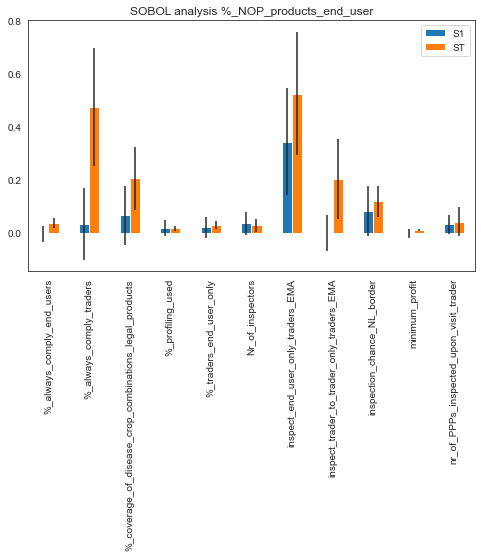

In [16]:
#Create the plot for the percentage of NOP products reaching the end-user
create_SOBOL_plot('%_NOP_products_end_user')

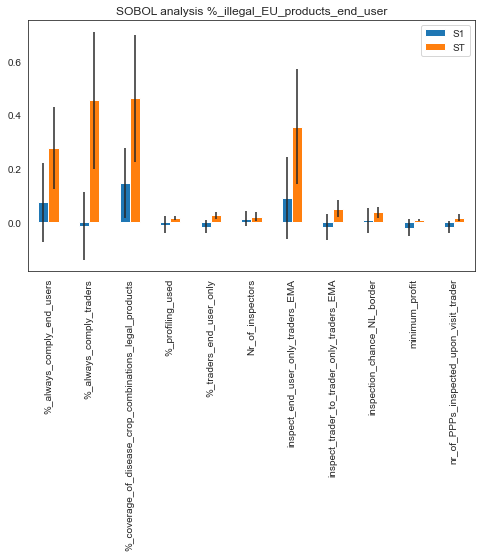

In [17]:
#Create the plot for the percentage of illegal products in the EU reaching the end-user
create_SOBOL_plot('%_illegal_EU_products_end_user')

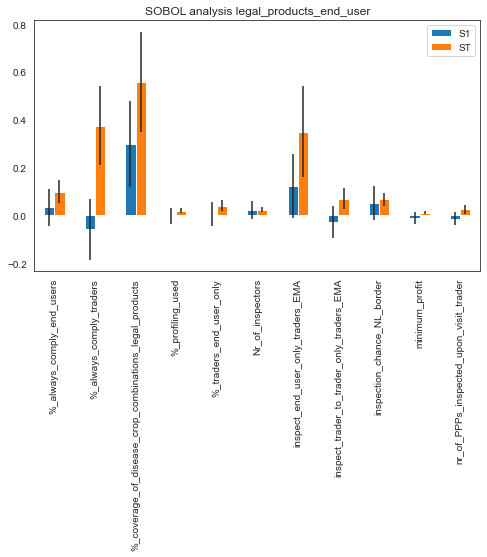

In [19]:
#Create the plot for the percentage of the legal products reaching the end-user
create_SOBOL_plot("legal_products_end_user")

In [28]:
#Create tables with the Sobol data for the NOP products reaching the end-user

#Analyze the Sobol data with a Salib problem
output_variable = 'NOP_products_end_user'
problem = get_SALib_problem(nl_model.uncertainties)
Si = sobol.analyze(problem, new_df[output_variable].to_numpy(), calc_second_order=True)
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}

#Create the plot
Si_df = pd.DataFrame(Si_filter, index=problem['names'])
Si_df = Si_df.round(decimals = 2)
Si_df

,ST,ST_conf,S1,S1_conf
%_always_comply_end_users,0.04,0.02,0.00,0.04
%_always_comply_traders,0.49,0.23,0.03,0.12
%_coverage_of_disease_crop_combinations_legal_products,0.17,0.09,0.05,0.09
%_profiling_used,0.02,0.01,0.02,0.03
%_traders_end_user_only,0.03,0.01,0.01,0.04
Nr_of_inspectors,0.03,0.02,0.03,0.05
inspect_end_user_only_traders_EMA,0.53,0.27,0.34,0.17
inspect_trader_to_trader_only_traders_EMA,0.19,0.14,0.01,0.06
inspection_chance_NL_border,0.12,0.07,0.07,0.09
minimum_profit,0.01,0.01,-0.00,0.02


In [29]:
#Create tables with the Sobol data for the NOP products reaching the end-user

#Analyze the Sobol data with a Salib problem
output_variable = '%_illegal_total'
problem = get_SALib_problem(nl_model.uncertainties)
Si = sobol.analyze(problem, new_df[output_variable].to_numpy(), calc_second_order=True)
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}

#Create the plot
Si_df = pd.DataFrame(Si_filter, index=problem['names'])
Si_df = Si_df.round(decimals = 2)
Si_df

,ST,ST_conf,S1,S1_conf
%_always_comply_end_users,0.13,0.07,0.03,0.10
%_always_comply_traders,0.47,0.26,0.01,0.14
%_coverage_of_disease_crop_combinations_legal_products,0.34,0.17,0.09,0.12
%_profiling_used,0.01,0.01,0.00,0.03
%_traders_end_user_only,0.02,0.01,-0.00,0.03
Nr_of_inspectors,0.02,0.02,0.03,0.04
inspect_end_user_only_traders_EMA,0.45,0.26,0.21,0.19
inspect_trader_to_trader_only_traders_EMA,0.09,0.06,-0.02,0.06
inspection_chance_NL_border,0.06,0.04,0.04,0.07
minimum_profit,0.01,0.00,-0.01,0.02
